<a href="https://colab.research.google.com/github/abdumhmd/kvasir-segmentation/blob/main/Segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!unzip /content/drive/MyDrive/kvasir-seg.zip
!pip install segmentation-models


In [ ]:
import os

!mkdir /content/Kvasir-SEG/images/img
!mv /content/Kvasir-SEG/images/*.jpg /content/Kvasir-SEG/images/img
!mkdir /content/Kvasir-SEG/masks/img
!mv /content/Kvasir-SEG/masks/*.jpg /content/Kvasir-SEG/masks/img
images=os.listdir('/content/Kvasir-SEG/images/img')
masks=os.listdir('/content/Kvasir-SEG/masks/img')

print(len(images))
print(len(masks))

1000
1000


(547, 626, 3)

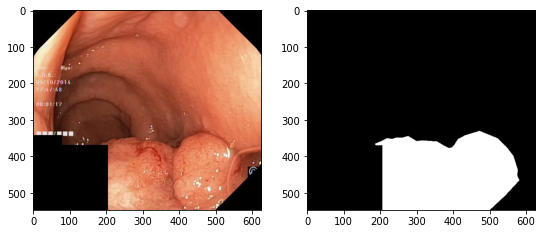

In [ ]:
import matplotlib.pyplot as plt
from random import choice

sample=choice(os.listdir('/content/Kvasir-SEG/images/img/'))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(9, 9)

img=plt.imread("/content/Kvasir-SEG/images/img/"+sample)
msk=plt.imread("/content/Kvasir-SEG/masks/img/"+sample)
axs[0].imshow(img)
axs[1].imshow(msk)

msk.shape


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import numpy as np


images_ = []
masks_ =  []
size=(256,256)
for i in tqdm(os.listdir('/content/Kvasir-SEG/images/img/')):
    
    

    img_name = "/content/Kvasir-SEG/images/img/"+ i 
    img_mask = "/content/Kvasir-SEG/masks/img/" + i 
    
    
    
    img = load_img(img_name, target_size=size)
    img = img_to_array(img)/255.
    
    mask = load_img(img_mask, target_size=size,color_mode='grayscale')
    mask = img_to_array(mask)/255.
    images_.append(img)
    masks_.append(mask)
    
images_ =  np.array(images_)
masks_ = np.array(masks_)
print(images_.shape, masks_.shape)
filename = 'maps_256.npz'
#savez_compressed(filename, images_, masks_)

100%|██████████| 1000/1000 [00:09<00:00, 107.82it/s]


(1000, 256, 256, 3) (1000, 256, 256, 1)


In [ ]:
from numpy import load

X_train, y_train = images_, masks_

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(600, 256, 256, 3)
(200, 256, 256, 3)
(200, 256, 256, 3)


In [ ]:
from segmentation_models.metrics import IOUScore,FScore
from segmentation_models.losses import JaccardLoss,DiceLoss
import tensorflow as tf


Segmentation Models: using `keras` framework.


In [ ]:

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    out = Activation('sigmoid')(x)
    
    
    model = Model(inputs=img_input, outputs=out)
    import time

    from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,TensorBoard
    weight_path="{}_weights.best.hdf5".format('cxr_reg')

    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', save_weights_only = True)

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                       patience=10,
                                       verbose=1, mode='min', min_delta=0.0002, cooldown=2, min_lr=1e-6)
    early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=20)
    NAME = "SegNet_kvasir-seg {}".format(int(time.time()))


    tfBoard=TensorBoard(log_dir='./graphs/{}'.format(NAME), histogram_freq=0,write_graph=True, write_images=True)
    callbacks_list = [checkpoint, early, reduceLROnPlat,tfBoard]
    model.compile(optimizer= Adam(lr=0.001), loss= DiceLoss()
                  , metrics=[IOUScore(threshold=.5),FScore(threshold=.5),'binary_accuracy', 'AUC'])
    model.summary()
    from tensorflow.keras.utils import plot_model
    plot_model(model, )
    hist = model.fit(X_train, y_train, epochs= epochs_num, batch_size= 8, validation_data= (X_valid, y_valid), callbacks=callbacks_list,verbose=1)
    
    model.save(savename)
    return model,hist

In [ ]:
model, hist = segnet(100, 'segnet_1_epoch.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_52 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_53 (Activation)  (None, 256, 256, 64)      0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 bn26 (BatchNormalization)   (None, 256, 256, 1)       4         
                                                                 
 activation_77 (Activation)  (None, 256, 256, 1)       0         
                                                                 
Total params: 33,393,669
Trainable params: 33,377,795
Non-trainable params: 15,874
_________________________________________________________________
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.6719 - iou_score: 0.2828 - f1-score: 0.4338 - binary_accuracy: 0.6787 - auc: 0.7866
Epoch 1: val_loss improved from inf to 0.74513, saving model to cxr_reg_weights.best.hdf5
75/75 [==============================] - 21s 244ms/step - loss: 0.6719 - iou_score: 0.2828 - f1-score: 0.4338 - binary_accuracy: 0.6787 - auc: 0.7866 - val_loss: 0.7451 - val_iou_score: 0.1466 - val_f1-score: 0.2535 - val_binary_accuracy: 0.1435 - val_auc: 0.5356 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - ETA: 0s - lo

In [ ]:
model.load_weights('cxr_reg_weights.best.hdf5')
scores=model.evaluate(X_test,y_test)
print(scores)

7/7 [==============================] - 2s 193ms/step - loss: 0.2586 - iou_score: 0.5935 - f1-score: 0.7440 - binary_accuracy: 0.9251 - auc: 0.8339
[0.2586089074611664, 0.5934543609619141, 0.7440454363822937, 0.9251068234443665, 0.8338503837585449]


122
189
125


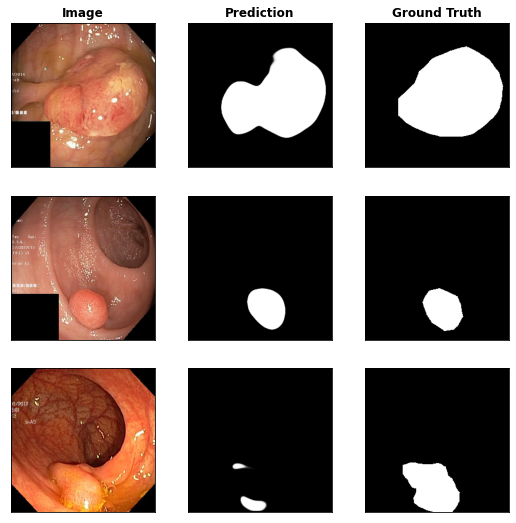

In [ ]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,3)
fig.set_size_inches(9, 9)


plt.setp(axs, xticks=[], yticks=[])

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[0][0].imshow(X_test[sample])
axs[0][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[0][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[1][0].imshow(X_test[sample])
axs[1][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[1][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");

sample=random.randrange(len(X_test))
print(sample)
i=np.expand_dims(X_test[sample],axis=0)
pred=model.predict(i)

axs[0][0].set_title('Image',
             fontweight ="bold")
axs[0][1].set_title('Prediction',
             fontweight ="bold")
axs[0][2].set_title('Ground Truth',
             fontweight ="bold")
axs[2][0].imshow(X_test[sample])
axs[2][1].imshow(np.reshape(pred[0], (256, 256)), cmap="gray");
axs[2][2].imshow(np.reshape(y_test[sample], (256, 256)), cmap="gray");